# strat98 test

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [55]:
#!/usr/bin/env python
__author__ = "aryaman"

import numpy as np
from numpy.polynomial.polynomial import polyfit
import math

nInst=100
currentPos = np.zeros(nInst)
stop_loss_value = np.zeros(nInst) # for normal buy-sell
trailing_profit = np.zeros(nInst) # can be substituted by trailing sl

def getMyPosition (prcSoFar):
    global currentPos
    global stop_loss_values
    global trailing_profit
    (nins,nt) = prcSoFar.shape #(100, prices
    rpos = np.zeros(100)

    # Get convergence values
    convergence_values = get_convergence_values(prcSoFar)   
    #print(f"\n {convergence_values} \n")
    for i in range(0, nins):
        #if i != 98:
        #    continue
        cnvg = convergence_values[i]
        new_price = prcSoFar[i][-1]
        if new_price < 0.995*cnvg:
            if currentPos[i] == 0: # no current pos in stock
                qty = ((10000 - (10000 % new_price)) / new_price)
                qty = math.floor(qty)
                #print(f"==> Simple buy {i} :: {qty}@{new_price} :: transaction value: {qty*new_price}")
                rpos[i] = qty
            if currentPos[i] < 0:
                # buy all short sells
                qty = currentPos[i]
                qty = math.floor(qty)
                #print(f"==> Settle short position {i} :: {qty}@{new_price} :: transaction value: {qty*new_price}")
                rpos[i] = rpos[i] - qty # qty is negative
        
        if new_price > cnvg:
            if currentPos[i] > 0:
                qty = currentPos[i]
                qty = math.floor(qty)
                #print(f"==> Simple sell {i} :: {qty}@{new_price} :: transaction value: {qty*new_price}")
                # short sell here
                qty_sll = ((10000 - (10000 % new_price)) / new_price)
                qty_sll = math.floor(qty_sll)
                #print(f"==> short sell {i} :: {qty_sll}@{new_price} :: transaction value: {qty_sll*new_price}")
                rpos[i] = -qty_sll - qty
        '''
        # Why does trailing profit perform worse ????? WTF?
        # Trailing profit implementation cant really figure out why it performs worse than simple sell
        if new_price > cnvg:
            if trailing_profit[i] < new_price:
                trailing_profit[i] = new_price
            elif trailing_profit[i] >= new_price:
                if currentPos[i] > 0:
                    qty = currentPos[i]
                    qty = math.floor(qty)
                    print(f"==> Simple sell {i} :: {qty}@{new_price} :: transaction value: {qty*new_price}")
                    #rpos[i] = -qty
                    # short sell here
                    qty_sll = ((10000 - (10000 % new_price)) / new_price)
                    qty_sll = math.floor(qty_sll)
                    print(f"==> short sell {i} :: {qty_sll}@{new_price} :: transaction value: {qty_sll*new_price}")
                    rpos[i] = -qty_sll - qty
                    trailing_profit[i] = 0
        '''
    currentPos += rpos
    
    return currentPos

"""
TODO: Find best number of sequences and sequence length

Get convergence values for all stocks

Returns: List of 100 convergence values
"""
def get_convergence_values(prcSoFar):
    SEQUENCE_LENGTH = 30
    SEQUENCES = 50
    convergence_values = []
    (nins, nt) = prcSoFar.shape
    for stock in prcSoFar:
        values = stock[-50:]
        tmp_convergence_values = []
        sequences = []
        for i in range(0, SEQUENCES):
            seq_tmp = []
            for j in range(0, SEQUENCE_LENGTH):
                seq_tmp.append(values[np.random.randint(0, len(values))])
            sequences.append(seq_tmp) 
        x_values = []
        for k in range(1, SEQUENCE_LENGTH+1):
            x_values.append(k)
        for seq in sequences:
            x = np.array(x_values)
            y = np.array(seq)
            
            m, b = polyfit(x, y, 1)
            pred = 69 * b + m
            ''' Why does second degree polynomial perform worse ??????
            a, b, c = polyfit(x, y, 2) # try second degree regression
            pred = a + b * 69 + c * 69 * 69
            '''
            tmp_convergence_values.append(pred)
        cnvg = 0
        for val in tmp_convergence_values:
            cnvg += val
        cnvg = cnvg/len(tmp_convergence_values)
        convergence_values.append(cnvg)
    return convergence_values   

### eval.py (modified)

In [56]:
# from teamName.py
#!/usr/bin/envblah python

import numpy as np
import pandas as pd
# from teamName import getMyPosition as getPosition

# Algorithm testing file. 
# Quantitative judging will be determined from output of this program.
# Judging will use unseeen, future price data from the same universe.

nInst = 0
nt = 0

# Commission rate.
commRate = 0.0050

# Dollar position limit (maximum absolute dollar value of any individual stock position).
dlrPosLimit = 10000

def loadPrices(fn):
    global nt, nInst
    df=pd.read_csv(fn, sep='\s+', header=None, index_col=None)
    nt, nInst = df.values.shape
    return (df.values).T

pricesFile="./prices250.txt"
prcAll = loadPrices(pricesFile)
print ("Loaded %d instruments for %d days" % (nInst, nt))

def calcPL(prcHist):
    cash = 0
    curPos = np.zeros(nInst)
    totDVolume = 0
    totDVolume0 = 0
    totDVolume1 = 0
    frac0 = 0.
    frac1 = 0.
    value = 0
    todayPLL = []
    (_,nt) = prcHist.shape
    for t in range(1, 251):  # changed this to (0, 251) from (201, 251)
        prcHistSoFar = prcHist[:,:t]
        newPosOrig = getPosition(prcHistSoFar)
        curPrices = prcHistSoFar[:,-1] 
        posLimits = np.array([int(x) for x in dlrPosLimit / curPrices])
        newPos = np.array([int(p) for p in np.clip(newPosOrig, -posLimits, posLimits)])
        deltaPos = newPos - curPos
        dvolumes = curPrices * np.abs(deltaPos)
        dvolume0 = np.sum(dvolumes[:50])
        dvolume1 = np.sum(dvolumes[50:])
        dvolume = np.sum(dvolumes)
        totDVolume += dvolume
        totDVolume0 += dvolume0
        totDVolume1 += dvolume1
        comm = dvolume * commRate
        cash -= curPrices.dot(deltaPos) + comm
        curPos = np.array(newPos)
        posValue = curPos.dot(curPrices)
        todayPL = cash + posValue - value
        todayPLL.append(todayPL)
        value = cash + posValue
        ret = 0.0
        if (totDVolume > 0):
            ret = value / totDVolume
            frac0 = totDVolume0 / totDVolume
            frac1 = totDVolume1 / totDVolume
        # old print
        # print ("Day %d value: %.2lf todayPL: $%.2lf $-traded: %.0lf return: %.5lf frac0: %.4lf frac1: %.4lf" % (t,value, todayPL, totDVolume, ret, frac0, frac1))
#         print ("Day %3d value: %9.2lf todayPL: $%8.2lf $-traded: %7.0lf return: %8.5lf frac0: %6.4lf frac1: %6.4lf" % (t,value, todayPL, totDVolume, ret, frac0, frac1))
    pll = np.array(todayPLL)
    (plmu,plstd) = (np.mean(pll), np.std(pll))
    annSharpe = 0.0
    if (plstd > 0):
        annSharpe = 16 * plmu / plstd
    
#     plt.figure(figsize=(10, 8))
#     sns.lineplot(x=range(1, 251), y=valueData)
    
    return (plmu, ret, annSharpe, totDVolume, todayPLL)

Loaded 100 instruments for 250 days


In [57]:
# Run calcPL here from eval.py
getPosition = getMyPosition

# Output
(meanpl, ret, sharpe, dvol, todayPLL1) = calcPL(prcAll)
print ("=====")
print ("mean(PL): %.0lf" % meanpl)
print ("return: %.5lf" % ret)
print ("annSharpe(PL): %.2lf " % sharpe)
print ("totDvolume: %.0lf " % dvol)

=====
mean(PL): 4625
return: 0.01614
annSharpe(PL): 21.84 
totDvolume: 71621521 


In [ ]:
todayPLL1[:5]

### below is modified strat98.py

In [59]:
#!/usr/bin/env python
__author__ = "aryaman"

import numpy as np
from numpy.polynomial.polynomial import polyfit
import math

nInst=100
currentPos = np.zeros(nInst)
stop_loss_value = np.zeros(nInst) # for normal buy-sell
trailing_profit = np.zeros(nInst) # can be substituted by trailing sl
posLimit = 10000


def getMyPosition (prcSoFar):
    global currentPos
    global stop_loss_values
    global trailing_profit
    (nins,nt) = prcSoFar.shape #(100, prices
    rpos = np.zeros(100)

    # Get convergence values
    convergence_values = get_convergence_values(prcSoFar)   
    #print(f"\n {convergence_values} \n")
    for i in range(0, nins):
        #if i != 98:
        #    continue
        cnvg = convergence_values[i]
        new_price = prcSoFar[i][-1]
        
        if new_price < 0.995*cnvg:  # buy
            rpos[i] = posLimit // new_price
        if new_price > cnvg:  # sell
            rpos[i] = -posLimit // new_price

    currentPos = rpos
    
    return currentPos

"""
TODO: Find best number of sequences and sequence length

Get convergence values for all stocks

Returns: List of 100 convergence values
"""
def get_convergence_values(prcSoFar):
    SEQUENCE_LENGTH = 30
    SEQUENCES = 50
    convergence_values = []
    (nins, nt) = prcSoFar.shape
    for stock in prcSoFar:
        values = stock[-50:]
        tmp_convergence_values = []
        sequences = []
        for i in range(0, SEQUENCES):
            seq_tmp = []
            for j in range(0, SEQUENCE_LENGTH):
                seq_tmp.append(values[np.random.randint(0, len(values))])
            sequences.append(seq_tmp) 
        x_values = []
        for k in range(1, SEQUENCE_LENGTH+1):
            x_values.append(k)
        for seq in sequences:
            x = np.array(x_values)
            y = np.array(seq)
            
            m, b = polyfit(x, y, 1)
            pred = 69 * b + m
            ''' Why does second degree polynomial perform worse ??????
            a, b, c = polyfit(x, y, 2) # try second degree regression
            pred = a + b * 69 + c * 69 * 69
            '''
            tmp_convergence_values.append(pred)
        cnvg = 0
        for val in tmp_convergence_values:
            cnvg += val
        cnvg = cnvg/len(tmp_convergence_values)
        convergence_values.append(cnvg)
    return convergence_values   

In [60]:
# Run calcPL here from eval.py
getPosition = getMyPosition

# Output
(meanpl, ret, sharpe, dvol, todayPLL2) = calcPL(prcAll)
print ("=====")
print ("mean(PL): %.0lf" % meanpl)
print ("return: %.5lf" % ret)
print ("annSharpe(PL): %.2lf " % sharpe)
print ("totDvolume: %.0lf " % dvol)

=====
mean(PL): 6363
return: 0.01333
annSharpe(PL): 26.54 
totDvolume: 119360438 


In [61]:
todayPLL2[:5]

[-2597.337349999987,
 62.54630000019097,
 5671.296399999905,
 5122.008700000006,
 9151.228649999946]

In [62]:
#!/usr/bin/env python
__author__ = "aryaman"

import numpy as np
from numpy.polynomial.polynomial import polyfit
import math

nInst=100
currentPos = np.zeros(nInst)
stop_loss_value = np.zeros(nInst) # for normal buy-sell
trailing_profit = np.zeros(nInst) # can be substituted by trailing sl
posLimit = 10000
commRate = 0.0050


def getMyPosition (prcSoFar):
    global currentPos
    global stop_loss_values
    global trailing_profit
    (nins,nt) = prcSoFar.shape #(100, prices
    rpos = np.zeros(100)

    # Get convergence values
    convergence_values = get_convergence_values(prcSoFar)   
    #print(f"\n {convergence_values} \n")
    for i in range(0, nins):
        #if i != 98:
        #    continue
        cnvg = convergence_values[i]
        new_price = prcSoFar[i][-1]
        
        if new_price < (1 - commRate) * cnvg:  # go long
            rpos[i] = posLimit // new_price
        elif new_price > (1 + commRate) * cnvg:  # go short
            rpos[i] = -posLimit // new_price
        else:
            rpos[i] = currentPos[i]  # no change

    currentPos = rpos
    
    return currentPos

"""
TODO: Find best number of sequences and sequence length

Get convergence values for all stocks

Returns: List of 100 convergence values
"""
def get_convergence_values(prcSoFar):
    SEQUENCE_LENGTH = 30
    SEQUENCES = 50
    convergence_values = []
    (nins, nt) = prcSoFar.shape
    for stock in prcSoFar:
        values = stock[-50:]
        tmp_convergence_values = []
        sequences = []
        for i in range(0, SEQUENCES):
            seq_tmp = []
            for j in range(0, SEQUENCE_LENGTH):
                seq_tmp.append(values[np.random.randint(0, len(values))])
            sequences.append(seq_tmp) 
        x_values = []
        for k in range(1, SEQUENCE_LENGTH+1):
            x_values.append(k)
        for seq in sequences:
            x = np.array(x_values)
            y = np.array(seq)
            
            m, b = polyfit(x, y, 1)
            pred = 69 * b + m
            ''' Why does second degree polynomial perform worse ??????
            a, b, c = polyfit(x, y, 2) # try second degree regression
            pred = a + b * 69 + c * 69 * 69
            '''
            tmp_convergence_values.append(pred)
        cnvg = 0
        for val in tmp_convergence_values:
            cnvg += val
        cnvg = cnvg/len(tmp_convergence_values)
        convergence_values.append(cnvg)
    return convergence_values   

In [63]:
# Run calcPL here from eval.py
getPosition = getMyPosition

# Output
(meanpl, ret, sharpe, dvol, todayPLL3) = calcPL(prcAll)
print ("=====")
print ("mean(PL): %.0lf" % meanpl)
print ("return: %.5lf" % ret)
print ("annSharpe(PL): %.2lf " % sharpe)
print ("totDvolume: %.0lf " % dvol)

=====
mean(PL): 6576
return: 0.01834
annSharpe(PL): 25.94 
totDvolume: 89635173 


In [64]:
todayPLL3[:5]

[0.0,
 -2397.7653500000015,
 6740.8760999999795,
 7140.159899999977,
 9559.660299999989]

### plotting results

In [65]:
import pandas as pd

In [66]:
df = pd.DataFrame(index=range(1, 251), 
                  data={'w/o shorting': todayPLL1,
                        'w/ shorting': todayPLL2,
                        'less position changes': todayPLL3})
df.head()

,w/o shorting,w/ shorting,less position changes
1,0.00000,-2597.33735,0.00000
2,-1647.95070,62.54630,-2397.76535
3,6460.96930,5671.29640,6740.87610
4,2912.47455,5122.00870,7140.15990
5,8100.21150,9151.22865,9559.66030


Text(0, 0.5, 'Cumulative p/L ($)')

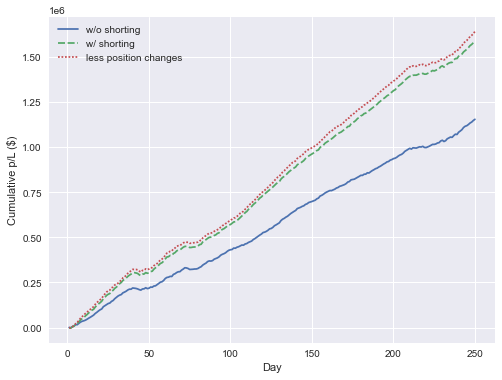

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.lineplot(data=df.cumsum())
plt.xlabel('Day')
plt.ylabel('Cumulative p/L ($)')